In [1]:
pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install torchhk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torchhk.vis import plot_individual_weight

import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import  mean_absolute_percentage_error, mean_absolute_error,mean_squared_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/VCB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)

df['Price']=df['Price'].replace(',','',regex=True).astype(float)

df = df.rename(columns={'Price': 'Close'})
df.head()



,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,41161.0,"41,391","41,698","41,084",1.38M,0.19%
2019-01-03,41161.0,"41,468","41,545","40,470",1.37M,0.00%
2019-01-04,41775.0,"40,931","41,775","40,393",1.67M,1.49%
2019-01-07,41929.0,"42,466","42,620","41,852",1.50M,0.37%
2019-01-08,42236.0,"42,236","42,390","41,852",1.68M,0.73%


In [5]:
df1 = df[['Close']]
df1

,Close
Date,
2019-01-02,41161.0
2019-01-03,41161.0
2019-01-04,41775.0
2019-01-07,41929.0
2019-01-08,42236.0
...,...
2023-06-12,101000.0
2023-06-13,102500.0
2023-06-14,102600.0


In [6]:
# 3. Scaler data
scaler=MinMaxScaler()
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test tỉ lệ
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
mean_close=train_data.mean()
std_close=train_data.std()


print(mean_close)
print(std_close)

0.3986712275188092
0.17421217528027758


In [9]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [10]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# 7.Chuẩn bị dữ liệu train
x = torch.from_numpy(X_train)
y = torch.from_numpy(y_train)
x = torch.tensor(x).to(torch.float)
y=  torch.tensor(y).to(torch.float)



<ipython-input-11-fed5ced163ac>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(torch.float)
<ipython-input-11-fed5ced163ac>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=  torch.tensor(y).to(torch.float)


In [12]:
# 8.Define mse_loss, kl_closs
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

In [13]:
# 9. Define BNN Model
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=mean_close, prior_sigma=std_close, in_features=40, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=mean_close, prior_sigma=std_close, in_features=100, out_features=1),
)


optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
kl_weight = 1/train_size

In [15]:
def custom_kl_loss(mu_0, log_sigma_0, mu_1, log_sigma_1) :
    kl = (log_sigma_0**2 + (mu_0-mu_1)**2)/(2*log_sigma_1**2)
    return kl.sum()

In [16]:
# 10. Fit mô hình với dữ liệu train
for step in range(5000):
    pre = model(x)
    mse = mse_loss(pre, y)

    # custom kl loss
    ckl = 0
    n = 0

    for m in model.modules() :
        if isinstance(m, (bnn.BayesLinear, bnn.BayesConv2d)):
            kl = custom_kl_loss(m.weight_mu, m.weight_log_sigma,
                                m.prior_mu, m.prior_log_sigma)
            ckl += kl
            n += len(m.weight_mu.view(-1))

            if m.bias :
                kl = custom_kl_loss(m.bias_mu, m.bias_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.bias_mu.view(-1))

        if isinstance(m, bnn.BayesBatchNorm2d):
            if m.affine :
                kl = custom_kl_loss(m.weight_mu, m.weight_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.weight_mu.view(-1))

                kl = custom_kl_loss(m.bias_mu, m.bias_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.bias_mu.view(-1))

    cost = mse + kl_weight*ckl

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()



print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([737])) that is different to the input size (torch.Size([737, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


- MSE : 0.04, KL : 1.28


In [17]:
# 11. Dự báo dữ liệu test
X_test = torch.from_numpy(X_test)
ytest = torch.from_numpy(ytest)

X_test = torch.tensor(X_test).to(torch.float)
ytest=  torch.tensor(ytest).to(torch.float)

y_pred=model(X_test)




<ipython-input-17-d8ea55870487>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).to(torch.float)
<ipython-input-17-d8ea55870487>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytest=  torch.tensor(ytest).to(torch.float)


In [18]:
# 12. Dự báo dữ liệu val
X_val = torch.from_numpy(X_val)
yval = torch.from_numpy(yval)
X_val = torch.tensor(X_val).to(torch.float)
yval=  torch.tensor(yval).to(torch.float)

y_pred_val=model(X_val)

<ipython-input-18-f064669fcde6>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).to(torch.float)
<ipython-input-18-f064669fcde6>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yval=  torch.tensor(yval).to(torch.float)


In [19]:
# 13. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred = y_pred.detach().numpy()
y_pred_val=y_pred_val.detach().numpy()
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

original_ytest = scaler.inverse_transform(ytest.reshape(-1,1))
original_yval = scaler.inverse_transform(yval.reshape(-1,1))

In [20]:
yval = yval.detach().numpy()
ytest=ytest.detach().numpy()

In [21]:
# 14. Đánh giá độ chính xác thuật toán bằng RMSE

valid_rmse = np.sqrt(np.mean((y_pred_val - original_yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - original_ytest)**2))
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

Validation RMSE: 26150.82
Testing RMSE: 28162.99


In [22]:
# 15. Đánh giá độ chính xác thuật toán bằng MDA
def mda_cal(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

valid_mda = mda_cal(original_yval, y_pred_val)
test_mda = mda_cal(original_ytest,y_pred)
print(f"Validation MDA: {valid_mda* 100:.2f}%")
print(f"Testing MDA: {test_mda*100:.2f}%")

Validation MDA: 42.86%
Testing MDA: 47.78%


In [23]:
# 16. Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = mean_absolute_percentage_error(original_yval, y_pred_val)
test_mape = mean_absolute_percentage_error(original_ytest ,y_pred)
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")

Validation MAPE: 27.94%
Testing MAPE: 36.04%


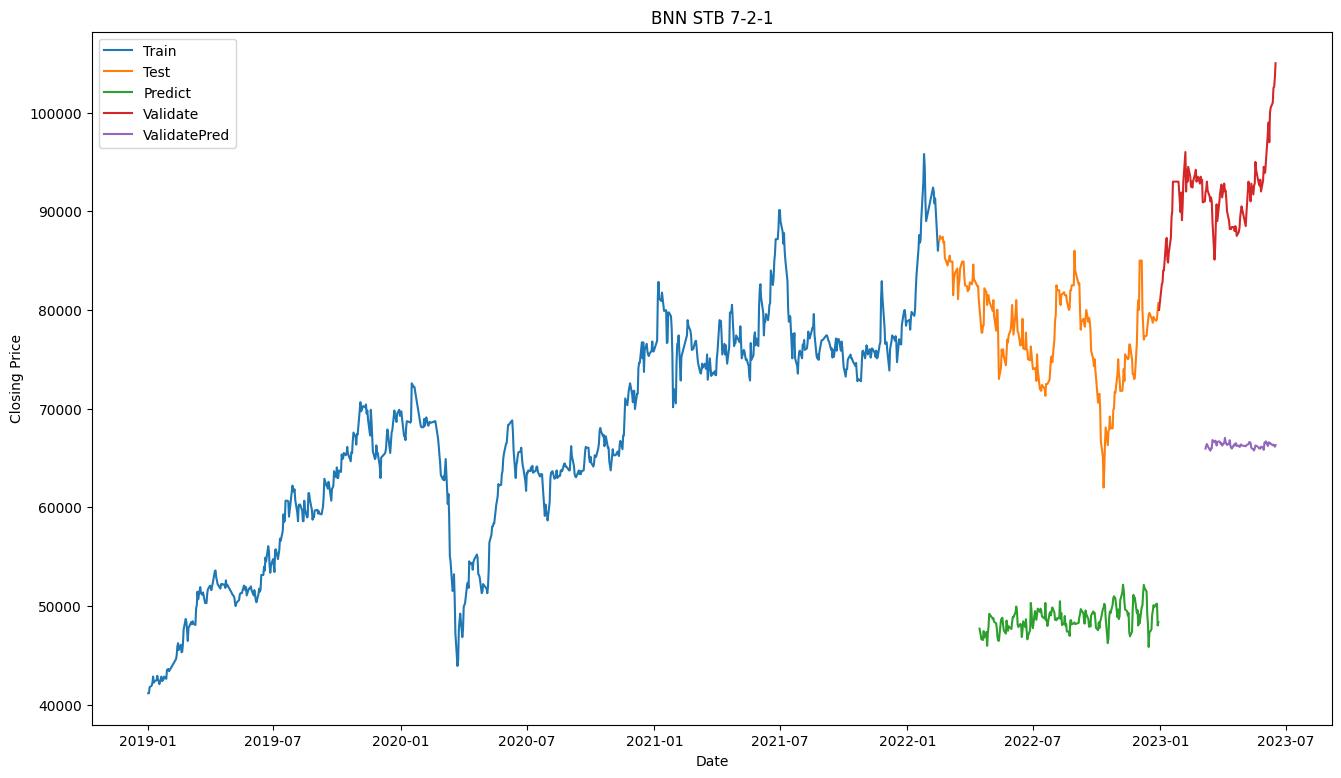

In [24]:

# 17.Vẽ hình
plt.figure(figsize=(16,9))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('BNN STB 7-2-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()